$$
Traitement \ d'images \\
Segmentation
$$

**Travail réalisé par:**



*   Turki Seddik



## I Segmentation par la méthode de croissance de région


**Imports**

In [ ]:
import numpy as np
import pandas as pd

from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


Pour segmenter une région `R` ayant un écart type de $\sigma_R$.

- on commence par un point germe `seed` d’un niveau de gris donné (c’est la valeur initiale de la moyenne de `R`)

- puis on croit la région autour du germe, en ajoutant à la région tous les points avoisinants dont les niveaux de gris I(x; y) vérifient la condition:

|I(x; y) - $\mu_R$| <= $\sigma_R$, où $\mu_R$ est la moyenne de `R`.

- Recalculer la moyenne de `R` après croissance
- Réitérer les opérations 2 et 3, jusqu’à ce qu’il n’y ait plus de croissance.

**Lire l'image**

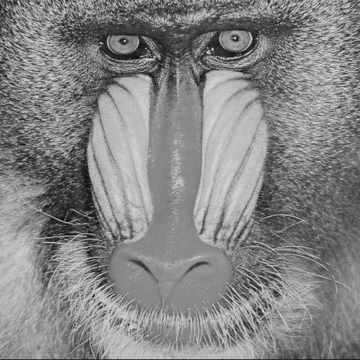

In [ ]:
image = Image.open('/content/mandrillgray.bmp')
image.resize((360,360))

$$$$

**Algorithme de Region Growing**

In [ ]:
def region_growing(img, seed, region_threshold=0.1, normalise=False, debug=False):
    # Parameters for region growing
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    region_threshold = region_threshold
    img = img.astype(np.float64)
    if normalise:
      img = img / 255.

    # Mean of the segmented region
    region_mean = img[seed]

    # Input image parameters
    height, width = img.shape
    image_size = height * width

    # Initialize segmented output image
    segmented_img = np.zeros((height, width), np.uint8)
    segmented_img[seed] = 255
    # Initialize queue for pixels to be checked
    queue = [seed]

    # Region growing loop
    while queue:
        # Get pixel from the queue
        h, w = queue.pop(0)

        # Check neighbors
        for dx, dy in neighbors:
            # Compute neighbor pixel position
            x_new, y_new = h + dx, w + dy

            # Boundary condition check
            if 0 <= x_new < height and 0 <= y_new < width and segmented_img[x_new, y_new] == 0:
                # Add pixel to the region if intensity difference is below threshold
                if abs(region_mean - img[x_new, y_new]) < region_threshold:
                    segmented_img[x_new, y_new] = 255
                    region_mean = (region_mean * (len(queue) + 1) + img[x_new, y_new]) / (len(queue) + 2)
                    if debug:
                      print(region_mean,end=', ')
                    queue.append((x_new, y_new))

    return segmented_img

**Choisir un point germe(en rouge) et un seuil fixe**

In [ ]:
seed = (256,256) # Germ Seed coords (the center of the image in this case)
th = 17 # th = 17 car l'image n'est pas normalisé entre 0 et 1
segmented_img = region_growing(np.array(image),
                               seed,
                               region_threshold=th)

In [ ]:
# Draw Germ
grayscale_image = Image.fromarray(segmented_img)
rgb_image = np.array(grayscale_image.convert('RGB'))
x,y = seed
r = 5
rgb_image[y-r:y+r,x-r:x+r,:] = (255,0,0)

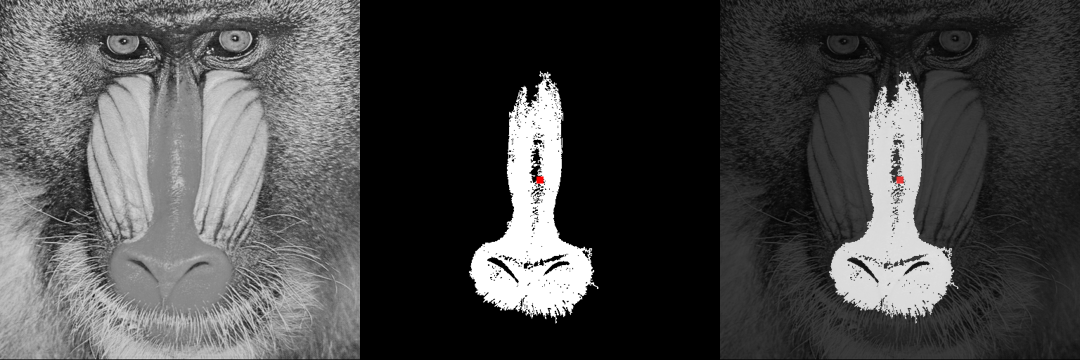

In [ ]:
# Visualise Images
size = (360,360)
rgb_image = Image.fromarray(rgb_image).resize(size)
true_image = image.convert('RGB').resize(size)
interpolated = Image.blend(true_image, rgb_image, 0.7)
aux = np.concatenate([np.array(true_image),np.array(rgb_image),np.array(interpolated)],axis=1)
Image.fromarray(aux)

**Tester plusieurs ecart-type**

[!] Le point en rouge est le point Germe


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


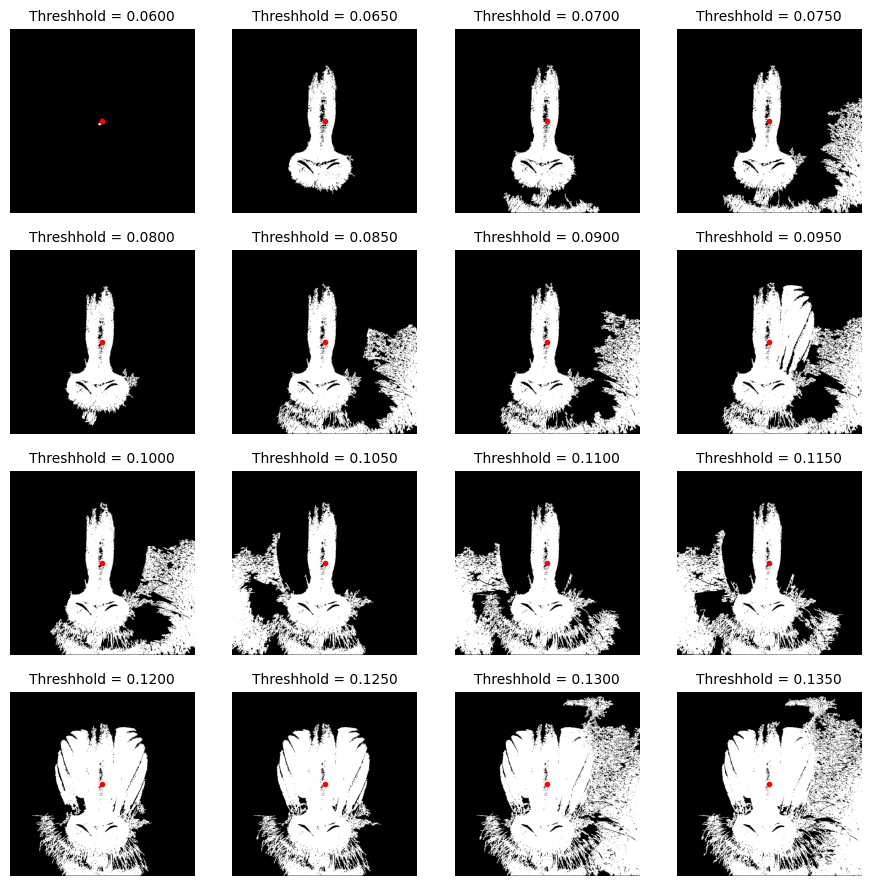

In [ ]:
seed = (256,256)
# here we will normalise the image to test different threshold between 0 and 1
print('[!] Le point en rouge est le point Germe')
plt.figure(figsize=(11,11))
for i,th in tqdm(enumerate(np.arange(0.06, 0.135, 0.005)),total=16):
  segmented_img = region_growing(np.array(image), seed, region_threshold=th,normalise=True)
  plt.subplot(4,4,i+1)
  plt.imshow(segmented_img,cmap='gray')
  plt.axis('off')
  plt.plot(seed[0],seed[1],marker='o',color='red',markersize=3)
  plt.grid(False)
  plt.title(f'Threshhold = {th:.4f}',fontsize=10)
plt.show()

$$$$

**Germe choisi avec le curseur**

In [ ]:
from IPython.display import HTML, display
from base64 import b64decode, b64encode
from PIL import Image

>pour choisir le point germe on a recourt à un script qui affiche l'image et capte la position du curseur(en pixel) sur l'image.

>Lors du clic sur l'image pour un point bien spécifique, les coordonnées sont ajoutés dans un tableau(plusieurs points peuvent être enregistrés)

>Le bouton `reset` réinitialise le tableau.

X,Y

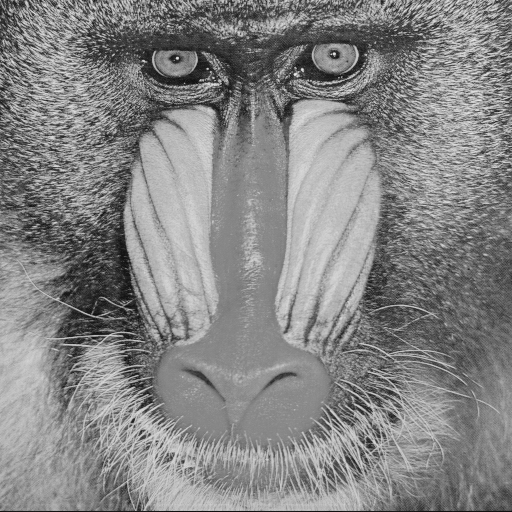

In [ ]:
canvas_html = """
<canvas id="canvas" width=%d height=%d></canvas>
<button id="resetButton">Reset</button>
<table id="coordinatesTable" border="1">
  <tr>
    <th>X</th>
    <th>Y</th>
  </tr>
</table>
<script>
var tableBody = document.querySelector('#coordinatesTable tbody');
var resetButton = document.getElementById('resetButton');
var coordinatesList = [];
var canvas = document.querySelector('canvas');
var ctx = canvas.getContext('2d');
var img = new Image();
img.src = 'data:image/jpeg;base64,%s';
img.onload = function() {
  // Draw the image at full size
  ctx.drawImage(img, 0, 0);
}
ctx.lineWidth = %d;
var button = document.querySelector('button');
var mouse = {x: 0, y: 0};
var table = document.getElementById('coordinatesTable');

// Function to draw crosshair lines when mouse hovers over the image
canvas.addEventListener('mousemove', function(e) {
  // Redraw the image to prevent it from disappearing
  ctx.drawImage(img, 0, 0);

  // Draw vertical and horizontal lines
  ctx.beginPath();
  ctx.moveTo(e.offsetX, 0);
  ctx.lineTo(e.offsetX, canvas.height);
  ctx.moveTo(0, e.offsetY);
  ctx.lineTo(canvas.width, e.offsetY);
  ctx.strokeStyle = 'blue';
  ctx.stroke();

  // Display coordinates with bigger font
  var coordinates = 'X: ' + e.offsetX + ', Y: ' + e.offsetY;
  ctx.fillStyle = 'green';
  ctx.font = 'bold 16px Arial';
  ctx.fillText(coordinates, e.offsetX + 10, e.offsetY - 10);
});

canvas.onmousedown = (e)=>{
  // Capture mouse coordinates when mouse is clicked
  var rect = canvas.getBoundingClientRect();
  var x = e.clientX - rect.left;
  var y = e.clientY - rect.top;
  coordinatesList.push([e.offsetX, e.offsetY]);

  // Add coordinates to table
  var newRow = table.insertRow();
  var cell1 = newRow.insertCell(0);
  var cell2 = newRow.insertCell(1);
  cell1.innerHTML = e.offsetX;
  cell2.innerHTML = e.offsetY;
}

resetButton.onclick = () => {
  coordinatesList = []; // Reset coordinates list
  tableBody.innerHTML = ''; // Clear table
}

</script>
"""

def draw_on_image(image_path, line_width=1):
    # Read image file
    with open(image_path, 'rb') as f:
        image_data = f.read()
    image_base64 = b64encode(image_data).decode('utf-8')

    # Get image dimensions
    with Image.open(image_path) as img:
        w, h = img.size

    # Display HTML with canvas and image
    display(HTML(canvas_html % (w, h, image_base64, line_width)))

# Example usage
draw_on_image('/content/mandrillgray.bmp')

**Segmenter l'image avec un point germe fixe choisi avec le curseur et un  écart-type fixe**

In [ ]:
# sce sont les points présentés dans le tableau des coordonnées
coordinates = """
145	198
"""

lines = coordinates.strip().split('\n')

coordinates = []
for line in lines:
    x, y = map(int, line.split())
    coordinates.append((x, y))

In [ ]:
seed = coordinates[-1]
th = 0.08
segmented_img = region_growing(np.array(image).copy(),
                               seed,
                               region_threshold=th,
                               normalise=True)

In [ ]:
# Draw Germ
grayscale_image = Image.fromarray(segmented_img)
rgb_image = np.array(grayscale_image.convert('RGB'))
x,y = seed
r = 5
rgb_image[y-r:y+r,x-r:x+r,:] = (255,0,0)

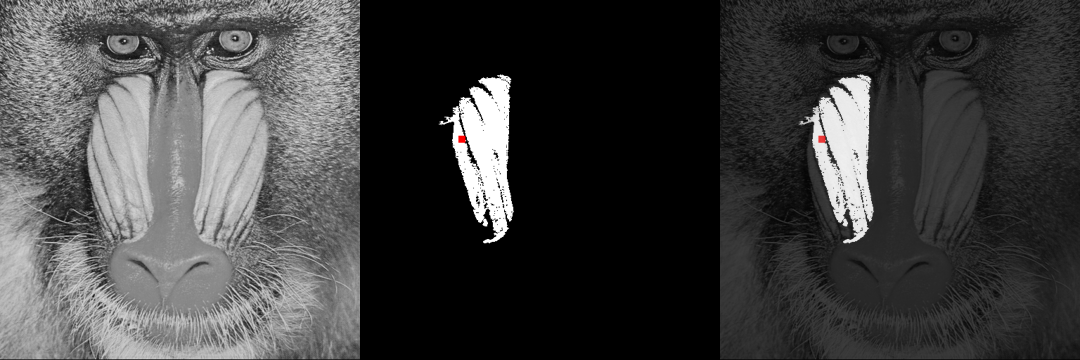

In [ ]:
# Visualise Images
size = (360,360)
rgb_image = Image.fromarray(rgb_image).resize(size)
true_image = image.convert('RGB').resize(size)
interpolated = Image.blend(true_image, rgb_image, 0.7)
aux = np.concatenate([np.array(true_image),np.array(rgb_image),np.array(interpolated)],axis=1)
Image.fromarray(aux)

**Segmenter l'image avec plusieurs écart-type**

[!] Le point en rouge est le point Germe


100%|██████████| 16/16 [00:11<00:00,  1.39it/s]


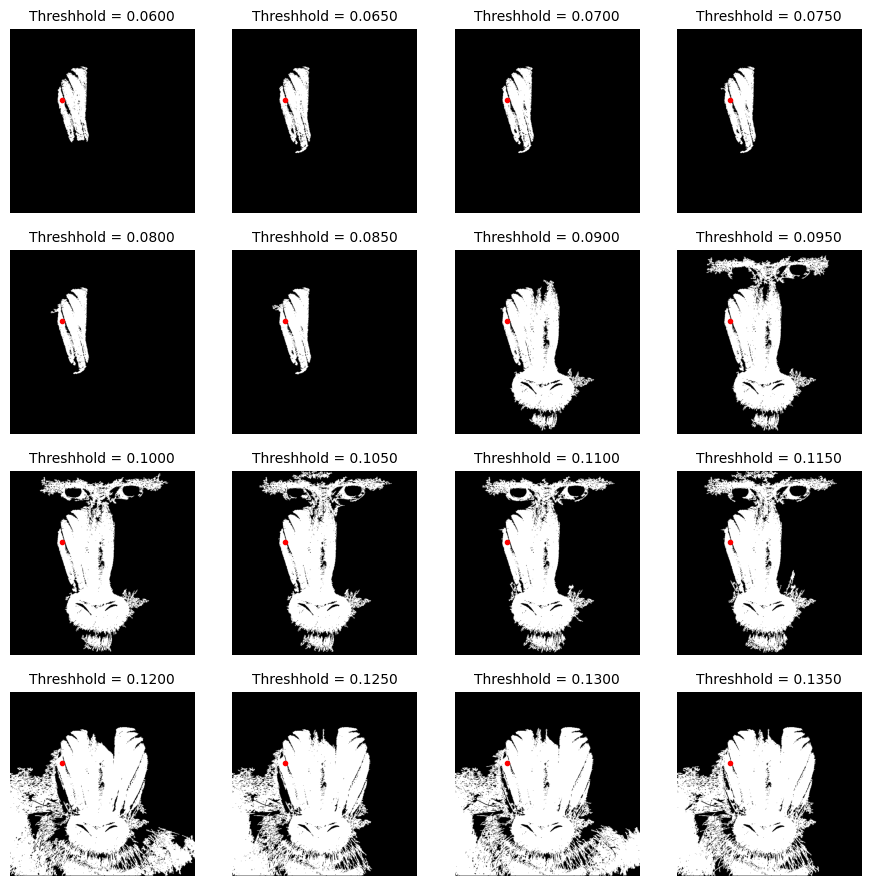

In [ ]:
print('[!] Le point en rouge est le point Germe')
plt.figure(figsize=(11,11))
for i,th in tqdm(enumerate(np.arange(0.06, 0.135, 0.005)),total=16):
  segmented_img = region_growing(np.array(image), seed, region_threshold=th,normalise=True)
  plt.subplot(4,4,i+1)
  plt.imshow(segmented_img,cmap='gray')
  plt.axis('off')
  plt.plot(seed[0],seed[1],marker='o',color='red',markersize=3)
  plt.grid(False)
  plt.title(f'Threshhold = {th:.4f}',fontsize=10)
plt.show()

> **Constatation**:

  * Pour deux régions différentes on a trouvé que le threshold le plus adéquat pour la segmentation de cette image est `0.08`.
  * Plus le threshold est bas moins la surface de la région segmentée est faible (moin d'information prise) et inversement plus le threshold augmente plus la région retient plus d'information
  * Il faut donc choisir le threshold le plus adéquat d'une manière empirique afin d'obtenir la région désirée.
  * À notre stade un écart-type de `0.08` semble être le choix optimale pour cet exemple

$$$$

**Segmenter 4 régions**

> Pour segmenter 4 régions différntes de l'image on peut choisir 4 coordonnées différents dans l'image puis appliquer cet algorithme sur ces 4 points (points germes) différents

> Pour choisir les points, on peut avoir recours au code qui retient les coordonnées avec le curseur, les points choisis sont présentés au-dessous

In [ ]:
coordinates = """
145	198
239	348
256	256
260 511
"""
lines = coordinates.strip().split('\n')

coordinates = []
for line in lines:
    x, y = map(int, line.split())
    coordinates.append((x, y))
print(coordinates)

[(145, 198), (239, 348), (256, 256), (260, 511)]


In [ ]:
th = 0.08
segmented_images = []
for seed in tqdm(coordinates):
  segmented_images.append(region_growing(np.array(image), seed, region_threshold=th,normalise=True))

100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


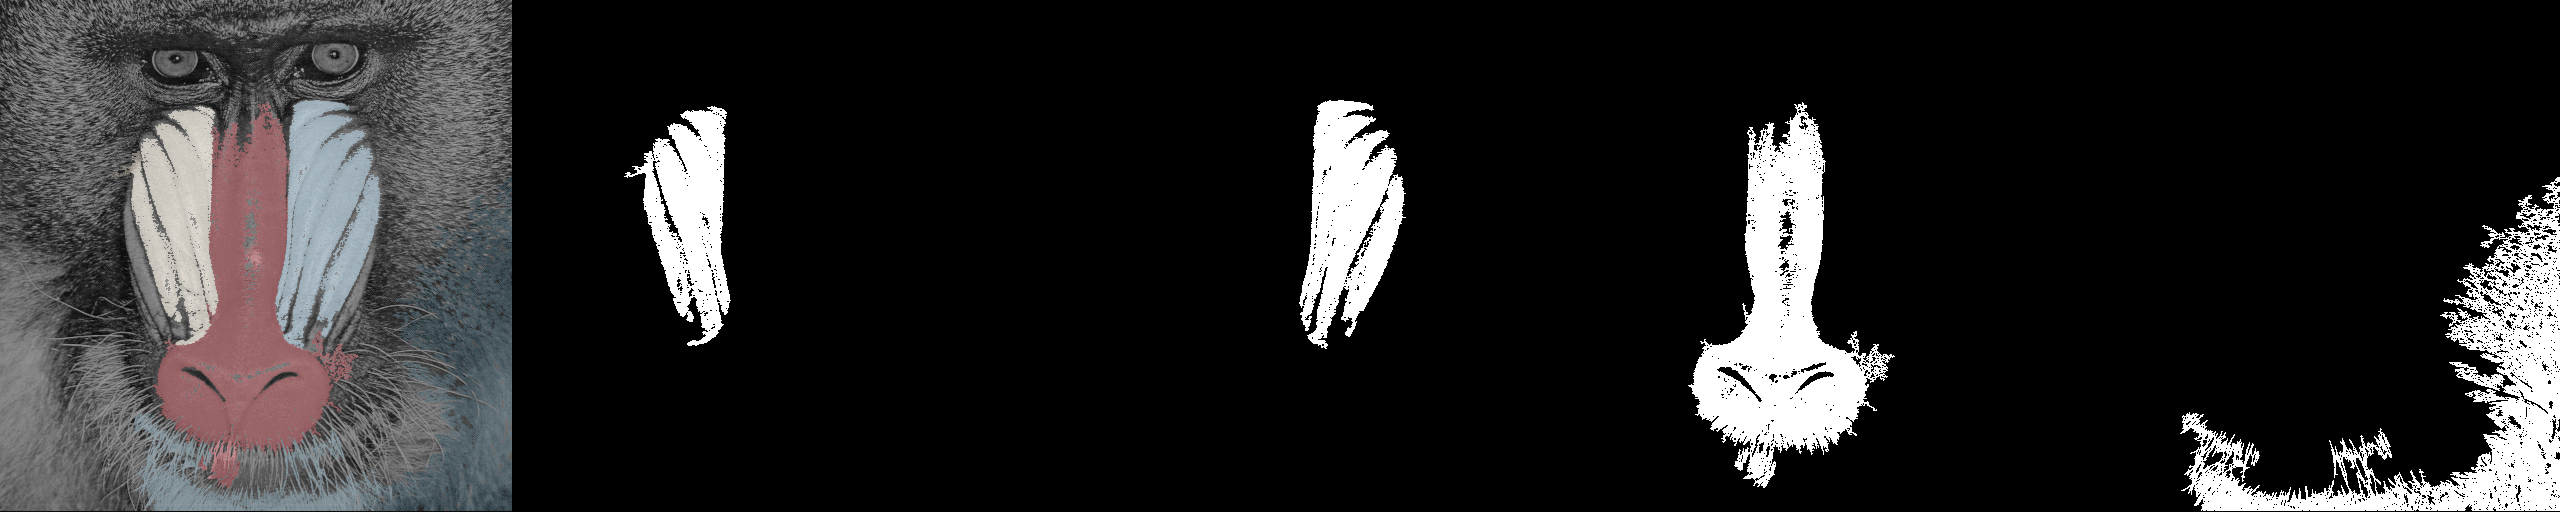

In [ ]:
colors = [
(253, 240, 213),
(102, 155, 188),
(193, 18, 31),
(0, 48, 73)]

true_image = image.convert('RGB')
interpolated = np.zeros_like(true_image)

for c,segmented_img in zip(colors,segmented_images):
  interpolated[segmented_img == 255] = c

interpolated = Image.fromarray(interpolated)
interpolated = Image.blend(interpolated, true_image, 0.7)
segmented_images = [Image.fromarray(x).convert('RGB') for x in segmented_images]
segmented_images = [interpolated] + segmented_images

Image.fromarray(np.concatenate(segmented_images,axis=1))